# data

> Web scraping and tools for data collection and processing

In [ ]:
#| default_exp data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sbavery/pseudometer/blob/main/nbs/01_data.ipynb)

In [ ]:
#| hide
## Google Colab / Enchant Library Install for Dictionaries
#!apt update
#!apt install enchant-2 --fix-missing
#!apt install -qq enchant-2

In [ ]:
#| export
import warnings
warnings.filterwarnings('ignore')
import requests
from bs4 import BeautifulSoup
import enchant
import re
import random
from collections import Counter
from fastai.text.all import *
import hashlib
import pickle

In [ ]:
#| hide
## Utility Function to Check GPU Status
def check_gpu():
    print("CUDA Available: ", torch.cuda.is_available())
    num_devices = torch.cuda.device_count()
    if num_devices > 0:
        for device in range(0,num_devices):
            print("Device", device, "|", torch.cuda.get_device_name(device), 
            "| Allocated:", round(torch.cuda.memory_allocated(device)/1024**3,1), "GB",
            "| Cached:", round(torch.cuda.memory_reserved(device)/1024**3,1), "GB")

torch.cuda.empty_cache()

In [ ]:
#| hide
check_gpu()

CUDA Available:  True
Device 0 | NVIDIA GeForce GTX 1050 Ti | Allocated: 0.0 GB | Cached: 0.0 GB


## Web Scraper

In [ ]:
#| export
class Webpage:
    def __init__(self, url):
        self.url = url
        self.hash = self.get_hash_str()
        self.requested = False
        self.page_text = ""
        self.html = ""
        self.links = []
        self.text = []
        self.cleaned_text = []
        self.most_common_words = []
    
    def get_page(self, headers, min_size, max_size):
        r = requests.get(self.url, stream=True, headers=headers)
        content_length = int(r.headers.get('Content-Length', 0))
        data = []
        length = 0

        if content_length > max_size:
            return None

        for chunk in r.iter_content(1024):
            data.append(chunk)
            length += len(chunk)
            if length > max_size:
                return None
        r._content = b''.join(data)
        if len(r.text) < min_size: return None
        return r.text

    def get_page_html(self, min_size=1000, max_size=2000000):
        user_agents = [ 
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36', 
            'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36', 
            'Mozilla/5.0 (iPhone; CPU iPhone OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148', 
            'Mozilla/5.0 (Linux; Android 11; SM-G960U) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.72 Mobile Safari/537.36' 
        ] 
        user_agent = random.choice(user_agents) 
        headers = {'User-Agent': user_agent} 
        self.page_text = self.get_page(headers, min_size, max_size)
        self.html = BeautifulSoup(self.page_text, "html.parser")
        self.requested = True

    def get_hash_str(self, inp=""):
        return hashlib.sha3_256((self.url+inp).encode()).hexdigest()

    def get_html_anchors(self, keyword="http"):
        for anchor in self.html.findAll('a'):
            link = anchor.get('href')
            if link == None or link == "":
                continue
            if keyword in link:
                self.links.append(link)
                
    def get_html_text(self, tags=["p"]):
        for tag in tags:
            for p in self.html.findAll(tag):
                p_text = p.getText().strip()
                if p_text == None or p_text == '':
                    continue
                self.text.append(p_text)

    def clean_html_text(self, max_words, enchant_dict="en_US", ignore=[], rx="[^a-zA-Z ]+", min_word_len=2):
        all_text = ' '.join(self.text).lower()
        regex_text = re.sub(rx,'',all_text).strip()
        split = regex_text.split()
        split = [word for word in split if word not in ignore]
        if enchant_dict != "": d = enchant.Dict(enchant_dict)
        for word in split:
            if len(self.cleaned_text) >= max_words: break
            if len(word) >= min_word_len:
                if enchant_dict == "":
                    self.cleaned_text.append(word)
                elif d.check(word): 
                    self.cleaned_text.append(word)

    def k_common_words(self, k=10, ignore=[]):
        if self.cleaned_text == "":
            text = self.text
        else:
            text = self.cleaned_text
        all_text = ' '.join(text).lower()
        split = all_text.split()
        split_ignore = [word for word in split if word not in ignore]
        counts = Counter(split_ignore)
        k_most_common = counts.most_common(k)
        self.most_common_words = k_most_common

    def save_text(self, path, fname):
        file = open(path+fname, 'wb')
        pickle.dump(self.text, file)
        file.close()

    def load_text(self, path, fname):
        file = open(path+fname, 'rb')
        self.text = pickle.load(file)
        file.close()

    def save_links(self, path, fname):
        file = open(path+fname, 'wb')
        pickle.dump(self.links, file)
        file.close()

    def load_links(self, path, fname):
        file = open(path+fname, 'rb')
        self.links = pickle.load(file)
        file.close()

In [ ]:
#| hide
#| export
def get_common_english_words():
    url = "https://gist.githubusercontent.com/deekayen/4148741/raw/98d35708fa344717d8eee15d11987de6c8e26d7d/1-1000.txt"
    common_english = Webpage(url)
    common_english.get_page_html(min_size=1000)
    english_words = common_english.html.getText().lower()
    english_words = english_words.split('\n')
    return english_words

#print(len(english_words),"most common English words")

In [ ]:
#| hide
url = "https://www.foxnews.com/opinion"
path = os.getcwd()+'/data/'
if os.path.isdir(path) is False: os.mkdir(path)
english_words=get_common_english_words()

In [ ]:
#| hide
test_page = Webpage(url)
test_page.get_page_html()
test_page.get_html_text()
test_page.get_html_anchors()
test_page.clean_html_text(500, ignore=english_words[:50], rx="[^a-zA-Z ]+")
test_page.save_text(path, test_page.hash+'.text')
test_page.save_links(path, test_page.hash+'.links')

In [ ]:
new_page = Webpage(url)
fname_text = new_page.hash+'.text'
fname_links = new_page.hash+'.links'
if os.path.isfile(path+fname_text): 
    new_page.load_text(path, fname_text)
    print("Loading Text")
else:
    new_page.get_page_html()
    new_page.get_html_text(tags=["p","h1","h2","h3","span"])
    new_page.save_text(path, fname_text)

if os.path.isfile(path+fname_links): 
    new_page.load_links(path, fname_links)
    print("Loading Links")
else:
    new_page.get_page_html()
    new_page.get_html_anchors()
    new_page.save_links(path, fname_links)
new_page.clean_html_text(500, ignore=english_words[:50], rx="[^a-zA-Z ]+")
new_page.k_common_words(k=5,ignore=english_words[:50])
print(len(new_page.cleaned_text))
' '.join(new_page.cleaned_text[:450])

Loading Text
Loading Links
500


'material may published broadcast rewritten redistributed fox news network rights reserved quotes displayed delayed least minutes market data provided powered implemented digital solutions legal statement mutual fund data provided second installment twitter files dropped evening leaders tech company engage content moderation practiced content stopped big government power grab would hurt businesses consumers antitrust zealots once feared video stores merging think deserve more power liberal authors king support do care defend conservative authors like too our fellow countries provide valuable lessons forging sustainable retirement programs building adequate retirement incomes policies expensive inflationary needs make away outlandish overspending so restore prosperity musk just break news also attempting break legacy medias grip news itself grant back us finally free after being wrongfully imprisoned big winners after swap include even girl company offering girls smart girls guide body 

In [ ]:
#| export
def get_page_all(url, k, max_words, ignore_text, ignore_common, path = None):
    page = Webpage(url)
    fname_text = page.hash+'.text'
    fname_links = page.hash+'.links'
    if path == None:
        page.get_page_html()
        page.get_html_text(tags=["p","h1","h2","h3","span"])
        page.get_html_anchors()
    else:
        if os.path.isfile(path+fname_text): 
            page.load_text(path, fname_text)
        else:
            page.get_page_html()
            page.get_html_text(tags=["p","h1","h2","h3","span"])
            page.save_text(path, fname_text)

        if os.path.isfile(path+fname_links): 
            page.load_links(path, fname_links)
        else:
            if page.html == "": page.get_page_html()
            page.get_html_anchors()
            page.save_links(path, fname_links)

    if page.text is not None:
        page.clean_html_text(max_words, ignore=ignore_text, rx="[^a-zA-Z ]+")
        page.k_common_words(k=k, ignore=ignore_common)
    return page

def get_all_links(url, dict, category, k, min_words=20, max_words=500, ignore_text=[], ignore_common=[], ignore_filenames=[".mp3",".jpg",".png"], max_links="", path=None):
    primary_page = get_page_all(url, k, max_words, ignore_text, ignore_common, path)
    if primary_page.cleaned_text is not []:
        dict[url] = [primary_page.cleaned_text, primary_page.most_common_words, category]
        if max_links == "" or max_links > len(primary_page.links): max_links=len(primary_page.links)
        
        for count, link in enumerate(primary_page.links[:max_links]):
            if all(x not in link for x in ignore_filenames):
                try:
                    page = get_page_all(link, k, max_words, ignore_text, ignore_common, path)
                    if page.cleaned_text is not []:
                        if len(page.cleaned_text) < min_words: continue
                        if len(page.cleaned_text) > max_words: page.cleaned_text = page.cleaned_text[:max_words]
                        if [page.cleaned_text, page.most_common_words] in dict.values(): continue
                        dict[link] = [page.cleaned_text, page.most_common_words, category]
                except:
                    pass
            if link in dict:
                res = str(len(dict[link][0]))+" words | "+str(dict[link][1][:3])
            else:
                res = "Rejected"
            progress_message = "%s link %4d/%4d | %s = %s %s" % (url, count, len(primary_page.links), link, res, 500*' ')
            sys.stdout.write("\r" + progress_message)
            sys.stdout.flush()
    else:
        print(url,"returned None, Skipping...")

In [ ]:
#| export

train_sources = {
    "pseudoscience":["http://www.ageofautism.com/",
 "http://www.naturalnews.com", 
 "https://foodbabe.com/starthere/",
 "http://www.chopra.com",
 "https://www.mercola.com/",
 "https://www.history.com/",
 "https://doctoroz.com/",
 "https://www.disclose.tv/",
 "https://nationalreport.net/",
 "https://heartland.org/",
 "https://www.dailymail.co.uk/",
 "https://www.motherjones.com/"],
    "science":["https://sciencebasedmedicine.org/",
 "https://www.hopkinsmedicine.org/gim/research/method/ebm.html",
 "https://www.bbc.com/news/science_and_environment",
 "https://www.nature.com/",
 "https://www.science.org/",
 "https://www.snopes.com/top/",
 "https://quackwatch.org/",
 "https://www.skepdic.com/",
 "http://scibabe.com/",
 "http://pandasthumb.org/",
 "https://skepticalscience.com/",
 "https://www.cdc.gov/",
 "https://apnews.com/",
 "https://www.economist.com/",
 "https://www.livescience.com/",
 "https://www.newscientist.com/"]
 }

In [ ]:
#| export
path = os.getcwd()+'/data/'
k = 30 # words
min_words = 50
max_words = 450
max_links = 30
ignore_text = ['the', 'of', 'to', 'and', 'a', 'in', 'it', 'that', 'for', 'on'] 
ignore_common = get_common_english_words()[:50]
ignore_filenames = [".mp3",".jpg",".png",".mp4",".jfif","facebook.com","twitter.com"]

In [ ]:
#| hide
#| export
def process_data(path, sources, k, min_words, max_words, ignore_text, ignore_common, 
            ignore_filenames, max_links):
    d_dl = {}
    d_proc = {}
    if os.path.isdir(path) is False: os.mkdir(path)

    for category in sources:
        for source in sources[category]:
            if category == "unknown":
                max_l = 0
            else:
                max_l = max_links
            get_all_links(source, d_dl, category, k, min_words, max_words, ignore_text, ignore_common, 
            ignore_filenames, max_l, path)

    for link in d_dl:
        text = d_dl[link][0]
        common_words = ' '.join([count[0] for count in d_dl[link][1]])
        if link not in d_proc:
            d_proc[link] = [' '.join(text), common_words, d_dl[link][2]]
    
    return d_proc

In [ ]:
d_train = process_data(path, train_sources, k, min_words, max_words, ignore_text, ignore_common, 
            ignore_filenames, max_links)

https://www.newscientist.com/ link   28/  33 | https://www.facebook.com/newscientist = Rejected                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
#| hide
d_counts = {}
for link in d_train:
    if d_train[link][2] in d_counts:
        d_counts[d_train[link][2]]+=Counter(d_train[link][1].split(' '))
    else:
        d_counts[d_train[link][2]]=Counter(d_train[link][1].split(' '))

for category in d_counts:
    print("####",category,k,"Most Common Words ####\n",d_counts[category].most_common(k),"\n\n")

#### pseudoscience 30 Most Common Words ####
 [('our', 90), ('more', 64), ('will', 55), ('us', 48), ('health', 46), ('has', 45), ('email', 40), ('about', 38), ('my', 36), ('no', 34), ('its', 34), ('news', 33), ('policy', 32), ('their', 31), ('new', 31), ('subscribe', 31), ('report', 30), ('national', 30), ('food', 30), ('free', 28), ('make', 28), ('if', 25), ('help', 25), ('people', 24), ('support', 24), ('privacy', 23), ('so', 22), ('most', 22), ('information', 22), ('life', 22)] 


#### science 30 Most Common Words ####
 [('our', 137), ('more', 136), ('about', 129), ('science', 114), ('new', 93), ('health', 74), ('us', 73), ('its', 70), ('will', 67), ('has', 64), ('menu', 64), ('medicine', 64), ('may', 52), ('news', 52), ('information', 46), ('world', 44), ('these', 43), ('used', 41), ('learn', 41), ('site', 41), ('years', 37), ('if', 36), ('been', 35), ('research', 35), ('close', 34), ('get', 33), ('patients', 33), ('search', 33), ('people', 32), ('access', 32)] 




## Data Preparation

In [ ]:
#| hide
df = pd.DataFrame.from_dict(d_train, orient='index', columns=['text', 'common_words', 'label'])
df.head()

,text,common_words,label
http://www.ageofautism.com/,by gaunt turtles all way down vaccine science myth was first published early was written has now been published authors are anonymous because doctors scientists who question veracity vaccine agenda get crushed this is most important book ever written about vaccines was written vaccines are not covered this book what this book does show is clear compelling evidence cheating lying with vaccines schedule children was written first foremost parents future parents is also great resource all others who want know truth about vaccines introduction page authors state if you choose continue reading ...,vaccine vaccines trials bob authors courage safety group adverse events way written being so has book page if will which claim gets control tested my turtles down science first published,pseudoscience
https://www.ageofautism.com/,by gaunt turtles all way down vaccine science myth was first published early was written has now been published authors are anonymous because doctors scientists who question veracity vaccine agenda get crushed this is most important book ever written about vaccines was written vaccines are not covered this book what this book does show is clear compelling evidence cheating lying with vaccines schedule children was written first foremost parents future parents is also great resource all others who want know truth about vaccines introduction page authors state if you choose continue reading ...,vaccine vaccines trials bob authors courage safety group adverse events way written being so has book page if will which claim gets control tested my turtles down science first published,pseudoscience
https://www.ageofautism.com/donate.html,hello your donation autism age is tax now use secure online donations scroll down their easy use form you can always send us paper or electronic check as well email me at any time with ideas suggestions or gentle critiques our is thank you ed cause unknown epidemic sudden deaths health defense transcend fear blueprint mindful leadership public health jr real bill gates big global war democracy public health health defense donate click cover buy book shop amazon support recent comments past current contributors connect search donate donate top,health donate defense public hello donation autism age tax now secure online donations scroll down their easy form always send us paper electronic check well email me any time ideas,pseudoscience
https://www.ageofautism.com/contact-us.html,autism age box ct ed cause unknown epidemic sudden deaths health defense transcend fear blueprint mindful leadership public health jr real bill gates big global war democracy public health health defense donate click cover buy book shop amazon support recent comments past current contributors connect search donate contact us top,health defense public donate autism age box ct ed cause unknown epidemic sudden deaths transcend fear blueprint mindful leadership jr real bill gates big global war democracy click cover buy,pseudoscience
https://www.ageofautism.com/exclusives.html,editorials from series by here come you had me at an elaborate fraud series deer special report what do epidemiological studies really tell us note from there are epidemiological studies here vaccines autism these studies represent most often cited papers by scientists public health officials members media when trying refute any evidence an association between vaccinations autism there are serious methodological limitations design flaws conflicts interest or other problems related each these studies these flaws have been pointed out by government officials other researchers medical review ...,autism studies health these series here public epidemiological vaccines officials limitations flaws study defense donate editorials come me elaborate fraud deer special report do really tell us note represent most,pseudoscience


In [ ]:
dls = TextDataLoaders.from_df(df, bs=16, text_col='text', label_col='label')
dls.show_batch(max_n=3)

,text,category
0,xxbos this blog ran from march has been replaced by no armed guards xxunk no raising smart kids ct no xxunk xxunk no xxunk design no autism no xxunk cold reading no jun experiences xxunk enemies reason xxunk xxunk parks mystery park closed no may peter evolution bacterial xxunk chiropractors run xxunk cam aids soldiers forced work as male prostitutes st no report tam xxunk skeptical journalists no science religion politics no mar xxunk begins filming what will become its hit show paranormal state ted hypocrisy psychic xxunk without clue critical thinking ct xxunk politics science young earth creationists poll reveals xxunk mercury health healing prayer studies find people who pray are talking themselves mice no march mostly republican war science no march abortion zoo takes intelligent design association advancement science xxunk educational practices no xxunk over cartoons no bizarre case tale torture murder rape xxunk satanic xxunk xxunk films,science
1,xxbos more pet news an older dog local kids had bullied was too xxunk respond his xxunk crossing streets train tracks kind cop protected duck family all way home xxunk since ancient times this food has become worldwide sensation thanks its nutrients but can your pet benefit from too read here learn if its good your pet when couple adopted sweet pit xxunk he was eager xxunk their two older cats xxunk put coat this lost freezing dog then carried miles down mountain left behind by his owners at an apartment building phoenix lived his own year dog person was never into cats until she met now she s xxunk would you know what do if your dog xxunk food or toy procedures are different small versus large dogs so be caught off xxunk not knowing learn steps now so you can act immediately if when happens no expense is,pseudoscience
2,xxbos dear reader is mother fundraising we have goal we simply can not afford miss no cute headlines or manipulative we explain as as we can how being nonprofit means everything us bottom line donations big small make up percent our budget this year are urgently needed this month all online gifts will be matched go twice as far until we hit our goal please pitch if you can right now donate is mother fundraising no cute headlines or manipulative we hope giving you as as we can will work raise we need raise this month donations make up percent our budget this year all online gifts will be matched go twice as far until we hit our goal donate afternoon writer tweeted what he called twitter files series internal documents he says he obtained from sources at social media company documents appear show internal conversations about twitters decision block,pseudoscience


In [ ]:
#| hide
torch.cuda.empty_cache()

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.608911,0.597006,0.710280,00:25


epoch,train_loss,valid_loss,accuracy,time
0,0.374137,0.579486,0.775701,00:46
1,0.324630,0.670924,0.719626,00:46
2,0.236349,0.464666,0.841121,00:47
3,0.167630,0.456388,0.859813,00:46


In [ ]:
#| hide
check_gpu()

CUDA Available:  True
Device 0 | NVIDIA GeForce GTX 1050 Ti | Allocated: 0.4 GB | Cached: 2.1 GB


In [ ]:
#| hide
#learn.show_results()

,input,target,predicted,probability,loss
0,xxbos about center center climate environmental policy at heartland institute is an independent authoritative source research commentary wide range environmental issues including climate change air water pollution public health energy policy has xxunk worldwide team leading scientists economic experts participate production books videos monthly weekly publications events government relations other activities more about center visit about page our position climate change center supports continued research causes effects climate change views heartlands spokespersons many experts works with are well summarized these documents global warming crisis is action plan president elements petitions testimony opposing xxunk finding events center has organized scores events including international conferences climate attended by more than people heartland nearly xxunk hosted first first energy conferences visit our channel watch highlights from those events trump administration folks few others praising heartland at conference video featuring trump speaking about energy opened event click xxunk view presentations more information about heartlands,pseudoscience,science,0.9933969974517822,7.950906276702881
1,xxbos about center center climate environmental policy at heartland institute is an independent authoritative source research commentary wide range environmental issues including climate change air water pollution public health energy policy has xxunk worldwide team leading scientists economic experts participate production books videos monthly weekly publications events government relations other activities more about center visit about page our position climate change center supports continued research causes effects climate change views heartlands spokespersons many experts works with are well summarized these documents global warming crisis is action plan president elements petitions testimony opposing xxunk finding events center has organized scores events including international conferences climate attended by more than people heartland nearly xxunk hosted first first energy conferences visit our channel watch highlights from those events trump administration folks few others praising heartland at conference video featuring trump speaking about energy opened event click xxunk view presentations more information about heartlands,pseudoscience,science,0.9933969974517822,5.020235061645508
2,xxbos red es con la con xxunk en en con la es en con la xxunk xxunk la mas red en para con la en la xxunk para xxunk para en la la para con la es no contra la la es lo mas popular editorial editorial xxwrep 4 en xxunk en poison control center hospital xxunk xxwrep 3 en mark en en green xxwrep 3 en lo mas popular xxunk,science,pseudoscience,0.9996476173400879,5.020235061645508


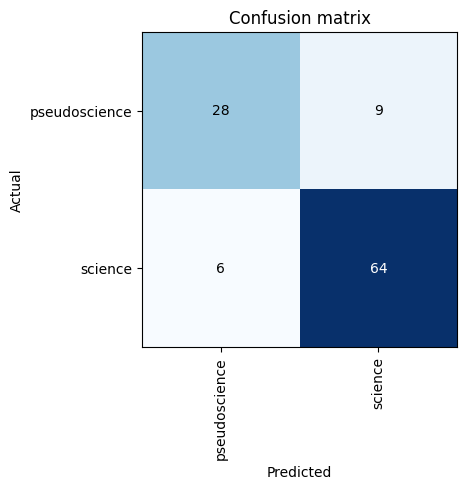

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(3)

## Making Model Predictions

In [ ]:
test_sources = {
    #'unknown':[],
    'pseudoscience':['https://www.foxnews.com/opinion',
'https://newspunch.com/',
'https://www.huffpost.com/'],
    'science':['https://www.si.edu/explore/science',
'https://www.theskepticsguide.org/about',
'https://arstechnica.com/']
}

In [ ]:
d_test = process_data(path, test_sources, k, min_words, max_words, ignore_text, ignore_common, 
            ignore_filenames, 0)

In [ ]:
test_df = pd.DataFrame.from_dict(d_test, orient='index', columns=['text', 'common_words', 'label'])
tokenized_df = tokenize_df(test_df, text_cols='text', tok_text_col='text') #returns a tuple
test_dl = learn.dls.test_dl(tokenized_df[0], with_labels=False)  #initialize the test dataloader
preds = learn.get_preds(dl=test_dl) # Get the predictions on your test data loader using [2]
preds

(tensor([[0.3757, 0.6243],
         [0.3974, 0.6026],
         [0.9644, 0.0356],
         [0.0011, 0.9989],
         [0.0044, 0.9956],
         [0.2065, 0.7935]]),
 None)

In [ ]:
d_pred = {}

for category in test_sources:
    for source in test_sources[category]:
        train_source = False
        page = get_page_all(source, k, max_words, ignore_text, ignore_common)
        length = len(page.cleaned_text)
        if  length < min_words:
            print("ERROR:",source,length,"words")
        else:
            common_words = ' '.join([count[0] for count in page.most_common_words])
            text = ' '.join(page.cleaned_text)
            with learn.no_bar(), learn.no_logging():
                prediction = learn.predict(text)
            #print(prediction)
            p = prediction[2][:].max().item()

            if source in d_train.keys(): train_source = True
            if category == prediction[0]:
                accuracy = p
            else:
                accuracy = 1-p
            d_pred[source] = [category, prediction[0], p, train_source, accuracy]

df = pd.DataFrame.from_dict(d_pred, orient='index', columns=['actual', 'prediction', 'probability', 'training source', 'accuracy'])

avg_accuracy = df['accuracy'].mean()
train_accuracy = df.loc[df['training source'] == True, 'accuracy'].mean()
test_accuracy = df.loc[df['training source'] == False, 'accuracy'].mean()

print("Average Accuracy =",avg_accuracy)
print("Train Source Accuracy =",train_accuracy)
print("Test Source Accuracy =",test_accuracy)
df
#df.loc[df['training source'] == False]

Average Accuracy = 0.7286035120487213
Train Source Accuracy = nan
Test Source Accuracy = 0.7286035120487213


,actual,prediction,probability,training source,accuracy
https://www.foxnews.com/opinion,pseudoscience,science,0.624349,False,0.375651
https://newspunch.com/,pseudoscience,science,0.752964,False,0.247036
https://www.huffpost.com/,pseudoscience,pseudoscience,0.960924,False,0.960924
https://www.si.edu/explore/science,science,science,0.998899,False,0.998899
https://www.theskepticsguide.org/about,science,science,0.995609,False,0.995609
https://arstechnica.com/,science,science,0.793503,False,0.793503


## Exporting and Loading the Model

In [ ]:
#learn.export('models/2022.12.07 Model v1 87pct')

In [ ]:
#learn = load_learner('models/2022.11.28 Model.pth', cpu=False)